In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Luca\anaconda3\envs\introml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


PyTorch Version: 1.8.1
Torchvision Version: 0.2.2
GPU is available? True


In [2]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST

In [3]:
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

# Train - test split

Code taken from https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb

In [4]:
#train-set initialization
x_d0 = mnist_trainset[0][0].size()[0]
x_d1 = mnist_trainset[0][0].size()[1]
x_d2 = mnist_trainset[0][0].size()[2]
N = x_d3 = len(mnist_trainset)
K = 10
x_train = torch.empty((N,x_d0*x_d1*x_d2), device=device)
y_train = torch.empty(N, dtype=torch.long)
for i in range(N): 
    x_train[i,:] = torch.reshape(mnist_trainset[i][0], (1, x_d0*x_d1*x_d2))
    y_train[i] = mnist_trainset[i][1]
x_train = torch.t(x_train)
#y_one_hot = torch.zeros(N, K).scatter_(1, torch.reshape(y_train, (N, 1)), 1)
#y_one_hot = torch.t(y_one_hot).to(device=device)
y_train = y_train.to(device=device)

#test-set initialization
N_test = x_d3_test = len(mnist_testset)
x_test = torch.empty((N_test,x_d0*x_d1*x_d2), device=device)
y_test = torch.empty(N_test, dtype=torch.long)
for i in range(N_test): 
    x_test[i,:] = torch.reshape(mnist_testset[i][0], (1, x_d0*x_d1*x_d2))
    y_test[i] = mnist_testset[i][1]
x_test = torch.t(x_test)
#y_test_one_hot = torch.zeros(N_test, K).scatter_(1, torch.reshape(y_test, (N_test, 1)), 1)
#y_test_one_hot = torch.t(y_test_one_hot).to(device=device)
y_test = y_test.to(device=device)

In [5]:
batch_size = 1000

dataset_test = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True, transform=torchvision.transforms.ToTensor()), 
  batch_size=100,
  shuffle=True
)
dataset_train = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
  batch_size=batch_size,
  shuffle=True
)

# Base architecture

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [6]:
input_size = 28*28
hidden_size = 1500
output_size = 10

In [7]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.fc_in = nn.Linear(self.input_size,self.hidden_size,bias=True) #fully connected input_layer
        self.fc_hid_1 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) #fully connected hidden_layer_1
        self.fc_hid_2 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) #dully connected hidden_layer_2
        self.fc_out = nn.Linear(self.hidden_size,self.output_size,bias=True)
    
    def forward(self,x):
        batch_size = x.shape[0]
        x = x.view(batch_size, self.input_size)
        x = self.relu(self.fc_in(x))
        x = self.relu(self.fc_hid_1(x))
        x = self.relu(self.fc_hid_2(x))
        x = self.fc_out(x)
        return x    

In [8]:
#initialize the model
mlp = MultiLayerPerceptron().to(device)

# Optimizers & Loss functions Definitions

1. SGD from pytorch 
2. CrossEntropyLoss function criterion

In [9]:
learning_rate = 0.001

cross_entropy = nn.CrossEntropyLoss()

optimizer_Adam = optim.Adam(mlp.parameters(), lr=learning_rate)

# Metrics

1. Accuracy

In [10]:
def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    
    @param predicted_logits: float32 tensor of shape (batch size, num classes)
    @param reference: int64 tensor of shape (batch_size) with the class number
    """
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

In [11]:
def train_model(model,dataset_train,dataset_test,optimizer,criterion,epochs):
    train_losses = []
    accuracies = []
    
    for epoch in range(epochs): # loop over the dataset multiple times
        epoch_loss = 0.0 
        model.train()
        running_loss = 0
        n_steps =0
        for batch_x,batch_y in dataset_train:
            n_steps = n_steps+1
            batch_x,batch_y = batch_x.to(device),batch_y.to(device)

            #Get output and evaluate with loss function
            predictions = model(batch_x)
            loss = criterion(predictions,batch_y)
            running_loss += loss.item() * len(batch_y)
    
            #Initialize optimizer
            optimizer.zero_grad()
            loss.backward()

            #Update the network
            optimizer.step()
        
        running_loss = running_loss / n_steps
        train_losses.append(running_loss)
        
        #Test the quality on the test set
        model.eval()
        accuracies_test = []
        
        for batch_x, batch_y in dataset_test:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            accuracies_test.append(accuracy(prediction, batch_y))
    
        print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))
        
        accuracies.append(sum(accuracies_test).item()/len(accuracies_test))
    return train_losses, accuracies

In [12]:
num_epochs = 20

start = time.time()

#train using sgd
train_losses_Adam, accuracies_test_Adam = train_model(mlp, dataset_train, dataset_test, optimizer_Adam, cross_entropy, num_epochs)

end = time.time()
print('\n')
print('The total time spent is', end - start)

Epoch 0 | Test accuracy: 0.95410
Epoch 1 | Test accuracy: 0.97160
Epoch 2 | Test accuracy: 0.97520
Epoch 3 | Test accuracy: 0.97830
Epoch 4 | Test accuracy: 0.98150
Epoch 5 | Test accuracy: 0.98110
Epoch 6 | Test accuracy: 0.97810
Epoch 7 | Test accuracy: 0.97950
Epoch 8 | Test accuracy: 0.98000
Epoch 9 | Test accuracy: 0.98160
Epoch 10 | Test accuracy: 0.97970
Epoch 11 | Test accuracy: 0.98260
Epoch 12 | Test accuracy: 0.97670
Epoch 13 | Test accuracy: 0.98270
Epoch 14 | Test accuracy: 0.97940
Epoch 15 | Test accuracy: 0.98260
Epoch 16 | Test accuracy: 0.98150
Epoch 17 | Test accuracy: 0.98380
Epoch 18 | Test accuracy: 0.98300
Epoch 19 | Test accuracy: 0.98180


The total time spent is 125.12215280532837


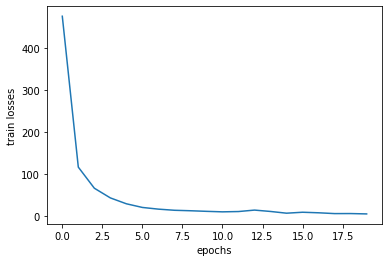

In [13]:
## We plot the train losses

plt.xlabel('epochs')
plt.ylabel('train losses')
plt.plot(np.arange(0,num_epochs), train_losses_Adam)
plt.show()

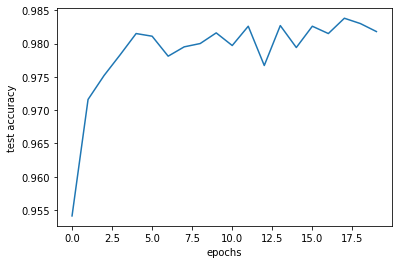

In [14]:
## We plot the test accuracy

plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.plot(np.arange(0,num_epochs), accuracies_test_Adam)
plt.show()